In [1]:
%matplotlib notebook
import sys
sys.path.insert(1, '../../../script/')

In [2]:
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
#import missingno as msno

from collections import defaultdict
from scipy.stats.stats import pearsonr

In [3]:
import cleaning_class as cl
%load_ext autoreload
%autoreload 2

In [4]:
df = pd.read_csv('../../data/training.csv')

In [5]:
cl.cleaning(df)

In [7]:
df.columns

Index(['IsBadBuy', 'Auction', 'VehicleAge', 'Transmission', 'WheelTypeID',
       'VehOdo', 'Nationality', 'Size', 'MMRAcquisitionAuctionAveragePrice',
       'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice',
       'MMRAcquisitonRetailCleanPrice', 'VNST', 'VehBCost', 'WarrantyCost'],
      dtype='object')

# Balance the dataset

In [8]:
df["IsBadBuy"].value_counts()

0    48062
1     6651
Name: IsBadBuy, dtype: int64

## Undersampling

In [9]:
df[df["IsBadBuy"]==0]["IsBadBuy"].value_counts()

0    48062
Name: IsBadBuy, dtype: int64

In [10]:
remove_n = 41411
drop_indices = np.random.choice(df[df["IsBadBuy"]==0].index, remove_n, replace=False)
df_subset = df.drop(drop_indices)

In [11]:
df_subset["IsBadBuy"].value_counts()

1    6651
0    6651
Name: IsBadBuy, dtype: int64

### Label Encoder

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [13]:
df_subset = pd.get_dummies(df_subset)
df_subset = pd.get_dummies(df_subset, columns=['WheelTypeID'])
df_subset.columns

Index(['IsBadBuy', 'VehicleAge', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice',
       'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice',
       'MMRAcquisitonRetailCleanPrice', 'VehBCost', 'WarrantyCost',
       'Auction_ADESA', 'Auction_MANHEIM', 'Auction_OTHER',
       'Transmission_AUTO', 'Transmission_MANUAL', 'Nationality_AMERICAN',
       'Nationality_OTHER', 'Nationality_OTHER ASIAN',
       'Nationality_TOP LINE ASIAN', 'Size_COMPACT', 'Size_CROSSOVER',
       'Size_LARGE', 'Size_LARGE SUV', 'Size_LARGE TRUCK', 'Size_MEDIUM',
       'Size_MEDIUM SUV', 'Size_SMALL SUV', 'Size_SMALL TRUCK',
       'Size_SPECIALTY', 'Size_SPORTS', 'Size_VAN', 'VNST_AL', 'VNST_AR',
       'VNST_AZ', 'VNST_CA', 'VNST_CO', 'VNST_FL', 'VNST_GA', 'VNST_IA',
       'VNST_ID', 'VNST_IL', 'VNST_IN', 'VNST_KY', 'VNST_LA', 'VNST_MA',
       'VNST_MD', 'VNST_MI', 'VNST_MN', 'VNST_MO', 'VNST_MS', 'VNST_NC',
       'VNST_NE', 'VNST_NH', 'VNST_NJ', 'VNST_NM', 'VNST_NV', 'VNST_OH',
       'V

### Train/Test partitioning

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
attributes = [col for col in df_subset.columns if col != 'IsBadBuy']
X = df_subset[attributes].values
y = df_subset['IsBadBuy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

### Parameter Tuning

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

In [17]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [18]:
param_list = {'criterion': ['gini', 'entropy'],
              'max_depth': [None] + list(np.arange(2, 50)),
              'min_samples_split': [2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
              'min_samples_leaf': [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
             }

clf = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1)

random_search = RandomizedSearchCV(clf, param_distributions=param_list, n_iter=200)
random_search.fit(X, y)
report(random_search.cv_results_, n_top=5)

C:\Users\Giulia\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Model with rank: 1
Mean validation score: 0.621 (std: 0.002)
Parameters: {'min_samples_split': 30, 'min_samples_leaf': 50, 'max_depth': 5, 'criterion': 'entropy'}

Model with rank: 2
Mean validation score: 0.620 (std: 0.000)
Parameters: {'min_samples_split': 70, 'min_samples_leaf': 80, 'max_depth': 5, 'criterion': 'entropy'}

Model with rank: 3
Mean validation score: 0.620 (std: 0.000)
Parameters: {'min_samples_split': 20, 'min_samples_leaf': 90, 'max_depth': 5, 'criterion': 'entropy'}

Model with rank: 4
Mean validation score: 0.619 (std: 0.005)
Parameters: {'min_samples_split': 10, 'min_samples_leaf': 100, 'max_depth': 7, 'criterion': 'entropy'}

Model with rank: 5
Mean validation score: 0.618 (std: 0.001)
Parameters: {'min_samples_split': 70, 'min_samples_leaf': 20, 'max_depth': 4, 'criterion': 'gini'}

Model with rank: 5
Mean validation score: 0.618 (std: 0.001)
Parameters: {'min_samples_split': 50, 'min_samples_leaf': 90, 'max_depth': 4, 'criterion': 'gini'}



### Perform Classification

In [19]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=30, min_samples_leaf=50)
clf = clf.fit(X_train, y_train)

In [20]:
y_pred = clf.predict(X_test)
y_pred_tr = clf.predict(X_train)

### Analyze the classification results

Feature importance

In [22]:
#for col, imp in zip(attributes, clf.feature_importances_):
#    print(col, imp)

<p>More important features:</p>
<ul>
    <li> VehicleAge (0.798)
    <li> VehBCost (0.070)
    <li> MMRAcquisitionAuctionAveragePrice (0.034)
    <li> VehOdo (0.030)
    <li> WarrantyCost (0.029)
    <li> Auction_MANHEIM (0.014)
    <li> VNST_GA (0.012)
    <li> Size_VAN (0.009)
</ul>

Visualize the decision tree

In [23]:
import pydotplus
from sklearn import tree
from IPython.display import Image

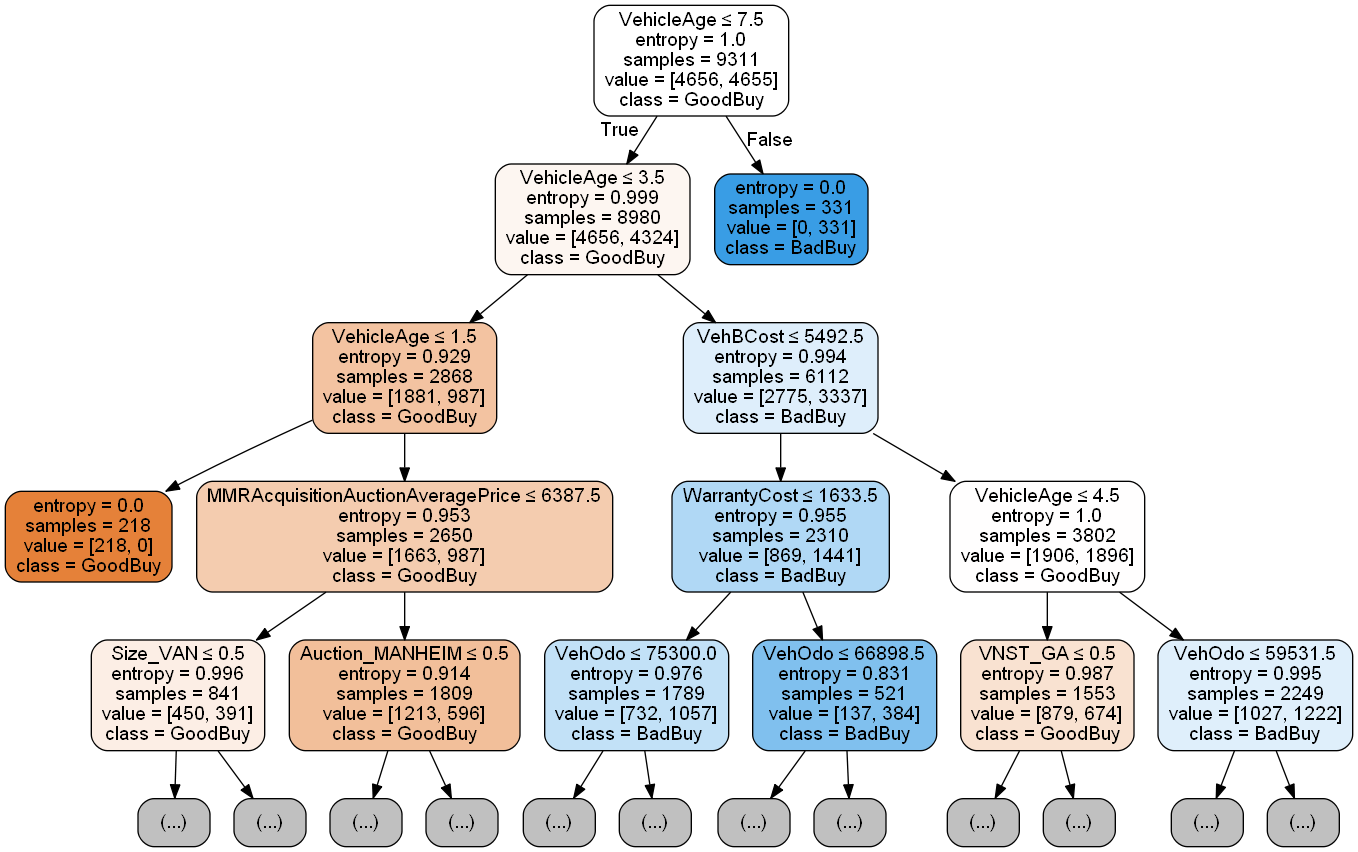

In [24]:
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=attributes,
                                class_names=['BadBuy' if x == 1 else 'GoodBuy' for x in clf.classes_],  
                                filled=True, rounded=True,  
                                special_characters=True,
                                max_depth=4)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

### Analyze the classification performance

In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [26]:
print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('Train F1-score %s' % f1_score(y_train, y_pred_tr, average=None))
print()

print('Test Accuracy %s' % accuracy_score(y_test, y_pred))
print('Test F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

Train Accuracy 0.6217377295671787
Train F1-score [0.62055591 0.62291221]

Test Accuracy 0.6341768980205462
Test F1-score [0.63481741 0.63353414]
              precision    recall  f1-score   support

           0       0.63      0.64      0.63      1995
           1       0.63      0.63      0.63      1996

    accuracy                           0.63      3991
   macro avg       0.63      0.63      0.63      3991
weighted avg       0.63      0.63      0.63      3991



array([[1269,  726],
       [ 734, 1262]], dtype=int64)

In [27]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)

roc_auc = roc_auc_score(y_test, y_pred, average=None)

0.634177377311013


<IPython.core.display.Javascript object>


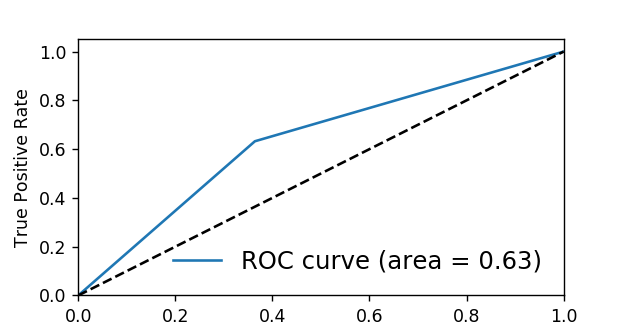

In [28]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 
plt.tick_params(axis='both', which='major')
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

## Oversampling

In [6]:
from imblearn.over_sampling import SMOTE

In [7]:
# Separate input features and target
y = df.IsBadBuy
X = df.drop('IsBadBuy', axis=1)

In [ ]:
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)